# SYDE 552 Assignment 2: Vision
### Due Monday, February 26, 11:59pm
### Value: 15% of total marks for the course

This assignment covers the mammilian vision system, including both questions about the biology itself and constructing computational models based on Regression and Convolutional Neural Networks.

You can work in groups to do the assignment, but your answers and code must be original to you. Your submission will be a filled-out copy of this notebook (cells for code and written answers provided).

# 1. The Vision System

The purpose of this part of the assignment is to test your knowledge of the brain’s visual system and the relationship between neurobiological features and computational properties. The best answers will discuss both function and anatomy, and will draw on specific anatomical examples to support theoretical claims. You are encouraged to discuss answers with your classmates, consult the slides notes, or use external resources -- but your answers must be your own! In particular, read the Kandel et al. chapters listed on the slides. Expect to write around 5 sentences for each 1 point.

**1.a) [2 marks]** The neurons in different parts of the brain are sensitive to different things, and can be thought of as different feature detectors.  For each of the types of neurons listed below, describe what feature they detect, their receptive fields, and how their connectivity to other neurons and/or their internal neural processes helps them to do this feature detection:
- Cones
- Sustained Ganglion Cells
- Transient Ganglion Cells
- Simple Cells

***- Cones***

Cones are most sensitive to a specific range of frequencies of light (3 types, with different ranges of sensitivity). Cones have the smallest receptive field,

***- Sustained Ganglion Cells***

Sustained ganglion cells respond to the presence or absence of a stimulus. If a stimulus is presented in the cell's receptive field, it will fire as long as the stimulus exists.

***- Transient Ganglion Cells***

Transient ganglion cells respond to changes in input

***- Simple Cells***

These cells respond optimally to a single stimulus type


**1. b) [1 marks]** Describe two instances where retinotopic organization facilitates visual processing.  For each example, be sure to mention its anatomical location and discuss how retinitopy contributes to the feature detection.

* Contours, decoding orientation (Lec 9 slide 9)
* Retinotopy exists in V1 (preserves same spatial relationships as in the retina)

**1. c) [2 marks]** Discuss the similarities and differences between convolutional neural networks and the visual system.

***- Similarities***

Similarities include that neurons closer to the input (low-level) have small receptive fields (as in rods and cones in the retinal) and those farther from the input layer have larger receptive fields. There is a clear hierarchical structure in the organization of a CNN that mimics that of the primate visual system.

***- Differences***

Differences, on the other hand, are that the visual system does not do convolution – we know this because biological neurons cannot share weights.

Dropout? Vesicle release failure..

# 2. Classifying Stimuli Using Regression

The retina transforms the light entering an eye into a particular set of features, which are then sent to the rest of the brain for further processing.  In this section we look at how neurons might detect patterns, and how that detection changes with different feature detectors.

The data we will use for this is the classic MNIST dataset

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# load MNIST dataset
mnist = torchvision.datasets.MNIST(root='.', download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 70833721.63it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 4864105.92it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 23899160.95it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13865013.66it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



The MNIST digits are 28x28 pixels each, each pixel is a value from 0 to 255, and there are 60,000 of them.  The raw data is in `mnist.data` and the target value (i.e. the actual digit) is in `mnist.targets`.  Here are the first 24 of each:

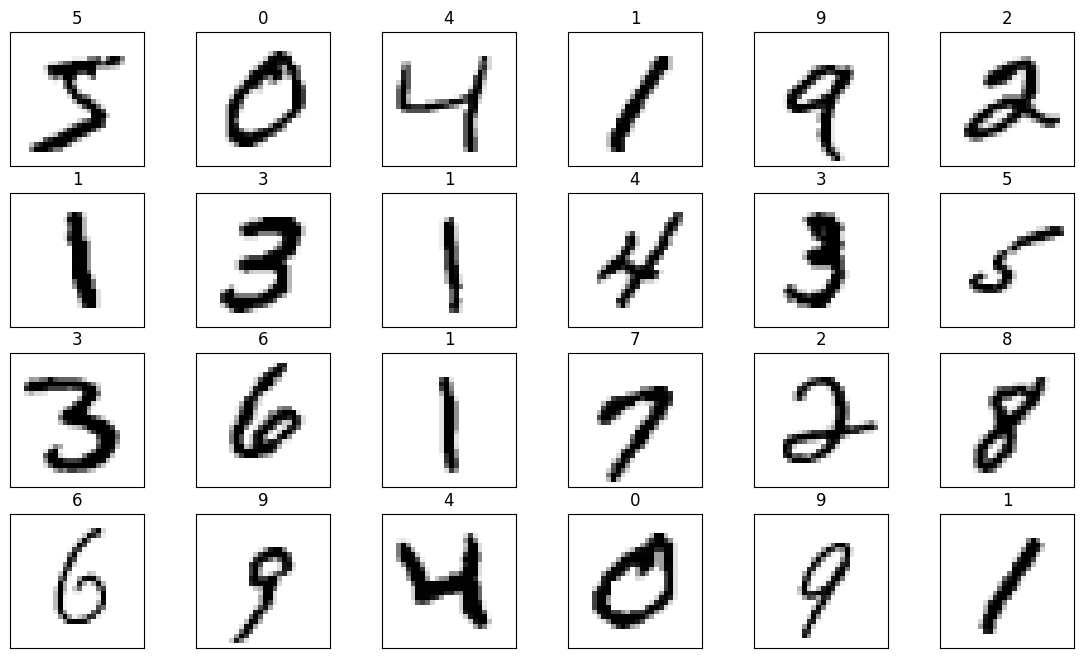

In [ ]:
%matplotlib inline
plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(mnist.data[i], vmin=0, vmax=255, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(mnist.targets[i]))

**2.a) [1 mark]** We can imagine the MNIST digits as 784 (28 times 28) input neurons.  We want to connect these 784 neurons to 10 output neurons, one for each digit, and see how accurately we can classify the digits.  

To find the weights in this question, we will use Ridge Regression.  `X` is the MNIST input data, divided by 255 to rescale it to between 0 and 1, and then reshaped to be a 60000x784 matrix

```
X = mnist.data.reshape((60000,28*28)).float()/255
```

The target data T is a "one-hot" representation of our outputs.  That is, instead of the desired output to be `5`, the output should be `[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]` and if the desired output should be `0`, that would be `[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]`.  

```
T = torch.nn.functional.one_hot(mnist.targets).float()
```

If our output is `Y=X @ W`, we need to find `W` such that `Y` is as close as possible to `T`.  For Ridge Regression, this is computed as

```
W = torch.inverse(X.T @ X + lambd*I) @ (X.T @ T)
```

where `I` is an identity matrix of the correct size (`torch.eye(784).float()`) and `lambd` is the $\lambda$ parameter that stops the regression from overfitting.

When building any sort of classifier model, we generally want to create the model using one set of data, and then test it on another set of data.  Here, we will use the first 5,000 data points for creating ("training") the model, and the other 55,000 for testing:

```
N = 5000
X_train, X_test = X[:N], X[N:]  # split X into two parts for training and testing
T_train, T_test = T[:N], T[N:]  # split T into two parts for training and testing
```

Given this data, you should find `W` using *only* the `X_train` and `T_train` data.  Once you find `W` you can apply it to the `X_train` and `X_test` to get `Y_train` and `Y_test`

```
Y_train = X_train @ W
Y_test = X_test @ W
```

Finally, you can compute the accuracy by determining when the output is the correct category.  Here we will do this by counting when the largest output value in each row in `Y` is at the same spot as the largest output value in each row in `T`:

```
accuracy_train = torch.sum(torch.argmax(Y_train, axis=1)==torch.argmax(T_train, axis=1))/len(Y_train)
accuracy_test = torch.sum(torch.argmax(Y_test, axis=1)==torch.argmax(T_test, axis=1))/len(Y_test)
```

- Compute the training and testing accuracy when $\lambda=1$ and we use the first 5,000 data points as for training (and test on the remaining 55,000).  Report both numbers.  
- Do we expect the testing accuracy to be larger or smaller than the training accuracy?  Why?


In [ ]:
# load MNIST data and convert to PyTorch tensors
X = mnist.data.reshape((60000,28*28)).float()/255 # collapses the image pixel data into a single dimension (1x784)
T = torch.nn.functional.one_hot(mnist.targets).float() # gets one-hot encoding of target labels (true labels)
T[:5] # print the first 5 one-hot encoded labels

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
# split up data into training and testing sets
N = 5000 # size of training set
X_train, X_test = X[:N], X[N:]  # split X into two parts for training and testing
T_train, T_test = T[:N], T[N:]  # split T into two parts for training and testing

In [ ]:
# calculate the weight matrix using the Ridge regression formula:
lambd = 1 # set lambda value for regularization
I = torch.eye(784).float() # identity matrix of size 784x784
W = torch.inverse(X_train.T @ X_train + lambd*I) @ (X_train.T @ T_train)

In [ ]:
# calculate predicted labels for training and testing sets using the weight matrix W
Y_train = X_train @ W
Y_test = X_test @ W

# calculate model accuracy using the predicted labels and true labels
accuracy_train = torch.sum(torch.argmax(Y_train, axis=1)==torch.argmax(T_train, axis=1))/len(Y_train) # divide by len to get percentage accuracy
accuracy_test = torch.sum(torch.argmax(Y_test, axis=1)==torch.argmax(T_test, axis=1))/len(Y_test)

In [ ]:
print(f"Train accuracy: {accuracy_train:.3f}") # ~90% accuracy
print(f"Test accuracy: {accuracy_test:.3f}") # ~82% accuracy

Train accuracy: 0.903
Test accuracy: 0.819


### Discussion Question:
***- Do we expect the testing accuracy to be larger or smaller than the training accuracy?  Why?***

It is expected that the testing accuracy will be slightly lower than the training accuracy, since the classifier has already seen all of the training data (but has not yet seen the test data). In other words, we can expect that the classification error will be slightly higher for the test set – this is consistent with the result above, where the accuracy in classifying training data is about 9% higher than the accuracy in classifying test data.

Intuitively, this makes sense because the test set might contain data samples that are completely different from anything the classifier has seen in the training set. Ideally, this would be avoided by training on a set that is (a) large enough, and (b) a representative sample of all data (so that the test set does not contain any surprises).

**2. b) [2 marks]**  Repeat part a) but vary the value of `lambd` from $10^{-4}$ to $10^5$.   You can use a `for` loop such as `for lambd in np.logspace(-5, 5, 11):`.  

- Generate a single plot that shows the training and testing accuracy.  Make sure to label your axes and the lines on the plot.  
- What is the best value for `lambd` (i.e. the value for which we get the best training accuracy).  
- Why does changing `lambd` affect the accuracy?  
- Why would having a large `lambd` value be good for making a biologically realistic model?

In [ ]:
lambda_values = np.logspace(-4, 5, 10) # create 11 values of lambda from 10^-4 to 10^5
acc_train = np.zeros(10)
acc_test = np.zeros(10)

# repeat steps above for different values of lambda:
for i, lambd in enumerate(lambda_values):
    W = torch.inverse(X_train.T @ X_train + lambd*I) @ (X_train.T @ T_train)
    Y_train = X_train @ W
    Y_test = X_test @ W
    acc_train[i] = torch.sum(torch.argmax(Y_train, axis=1)==torch.argmax(T_train, axis=1))/len(Y_train)
    acc_test[i]  = torch.sum(torch.argmax(Y_test, axis=1)==torch.argmax(T_test, axis=1))/len(Y_test)

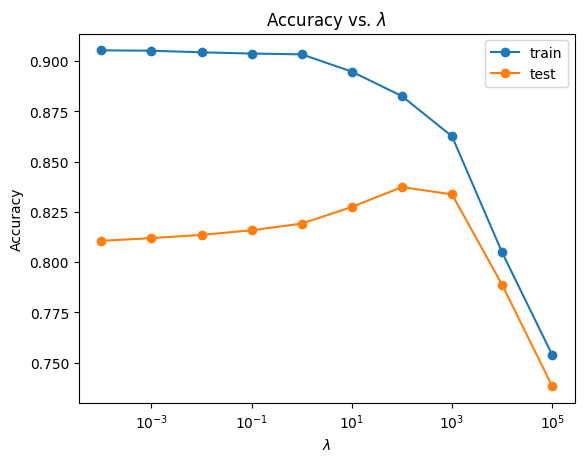

In [ ]:
# plot train and test accuracy vs. lambda
fig, ax = plt.subplots()
ax.plot(lambda_values, acc_train, 'o-', label='train')
ax.plot(lambda_values, acc_test, 'o-', label='test')
ax.set_title('Accuracy vs. $\lambda$')
ax.set(xlabel='$\lambda$', ylabel='Accuracy')
ax.set(xscale='log')
ax.legend()
plt.show()

In [ ]:
print(f"Best train lambda value: {lambda_values[np.argmax(acc_train)]}") # 10^-4
print(f"Best test lambda value: {lambda_values[np.argmax(acc_test)]}") # 10^2

Best train lambda value: 0.0001
Best test lambda value: 100.0


### Discussion Questions:
***- What is the best value for `lambd` (i.e. the value for which we get the best training accuracy?***

The best _train_ accuracy is seen when we use a `lambd` value of 10e-4 (highest point of blue curve). However, we would likely want to choose a `lambd` value that will give us the highest _test accuracy_, since this is more reflective of how the system will perform in practice. This value is comparatively much larger, at $\lambda = 100$. This indicates that a larger `lambd` value is required to prevent overfitting to the (relatively small) training dataset that we are using.

***- Why does changing `lambd` affect the accuracy?***

`lambd` is the regularization factor in Ridge regression and its purpose is to prevent the model from choosing overly large weights (i.e., overfitting).

***- Why would having a large `lambd` value be good for making a biologically realistic model?***

A larger value of `lambd` will increase the realism of the model because bioligical systems are trained on massive amounts of data. In this way, the `lambd` value of biological systems is large, since these systems are naturally biased against having large 'weights' in order to maximize generalizability.

**2. c) [1 mark]** The input we have used so far is not very realistic.  In real life, when we see written digits, they are under a wide range of lighting conditions. For this question, we change `X` by scaling it randomly and adding a random background brightness.

```
X = mnist.data.reshape((60000,28*28)).float()/255
X = X*(1-2*torch.rand(60000)[:,None]) + torch.rand(60000)[:,None]
```

To see what this looks like, here is how you can plot it:

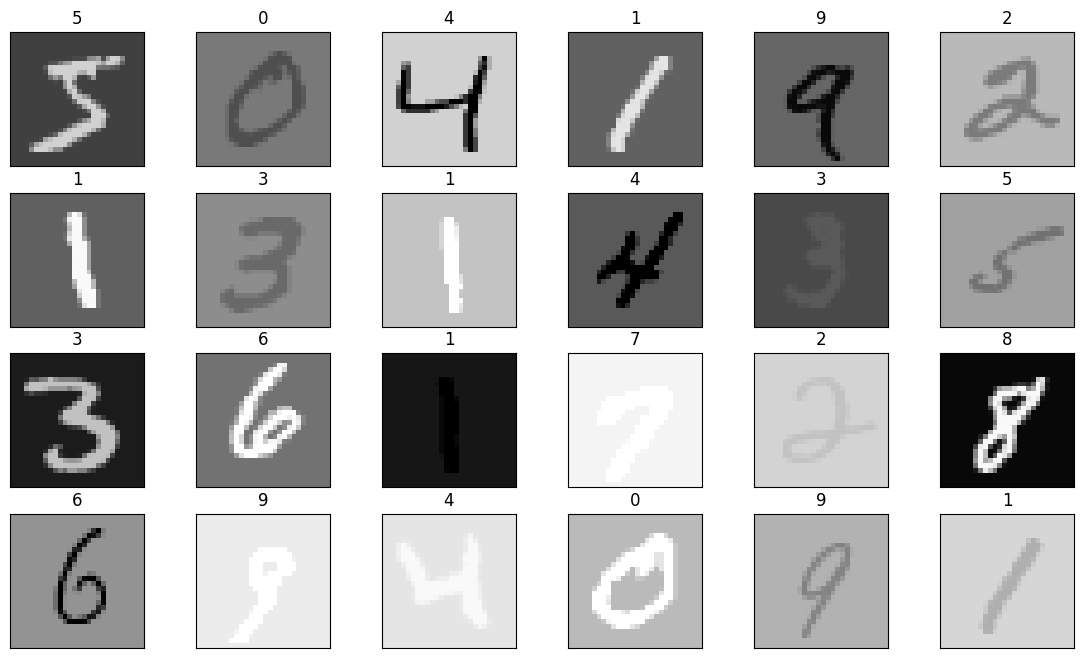

In [ ]:
# X = mnist.data.reshape((60000,28*28)).float()/255
X_noisy = X*(1-2*torch.rand(60000))[:,None] + torch.rand(60000)[:,None]

plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(X_noisy[i].reshape(28,28), vmin=0, vmax=1, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(mnist.targets[i]))


- Generate the same plot as in 2b) but for this new dataset.  
- Is this a harder or easier task than with the original dataset?
- Is this new dataset more like the data at the retina or like the data in the ganglion cells?
- Is the original dataset more like the data at the retina or like the data in the ganglion cells?

In [ ]:
# split up new data into training and testing sets
N = 5000 # keep train/test sets the same size
X_train_noisy, X_test_noisy = X_noisy[:N], X_noisy[N:]
T_train, T_test = T[:N], T[N:]

In [ ]:
# repeat the steps above in 2b):
lambda_values = np.logspace(-4, 5, 10) # create 11 values of lambda from 10^-4 to 10^5
acc_train_noisy = np.zeros(10)
acc_test_noisy = np.zeros(10)

for i, lambd in enumerate(lambda_values):
    W = torch.inverse(X_train_noisy.T @ X_train_noisy + lambd*I) @ (X_train_noisy.T @ T_train)
    Y_train_noisy = X_train_noisy @ W
    Y_test_noisy = X_test_noisy @ W
    acc_train_noisy[i] = torch.sum(torch.argmax(Y_train_noisy, axis=1)==torch.argmax(T_train, axis=1))/len(Y_train_noisy)
    acc_test_noisy[i]  = torch.sum(torch.argmax(Y_test_noisy, axis=1)==torch.argmax(T_test, axis=1))/len(Y_test_noisy)

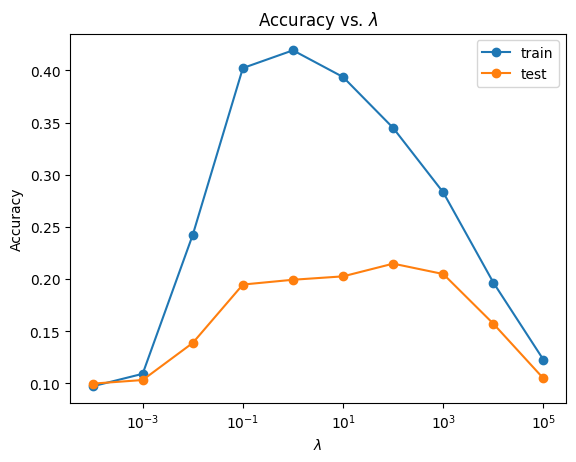

In [ ]:
# plot train and test accuracy vs. lambda
fig, ax = plt.subplots()
ax.plot(lambda_values, acc_train_noisy, 'o-', label='train')
ax.plot(lambda_values, acc_test_noisy, 'o-', label='test')
ax.set_title('Accuracy vs. $\lambda$')
ax.set(xlabel='$\lambda$', ylabel='Accuracy')
ax.set(xscale='log')
ax.legend()
plt.show()

### Discussion Questions:
***- Is this a harder or easier task than with the original dataset?***

This task is much harder than with the original dataset, as seen by the reduced accuracy scores in both training and testing. This makes sense because there is significantly more variation in this data, so the classifier needs to be able to accommodate a wider range of inputs. These transformations represent noise in the incoming signal, which occurs in real-world scenarios where parts of the data migt be obscured or missing. Though the difficulty of this task is increased, training on non-ideal data ensures that the system is more likely to perform well (i.e. more robust) under a variety of circumstances.

***- Is this new dataset more like the data at the retina or like the data in the ganglion cells?***

The new data is more like the raw data coming into the retina, which has to accommodate varied levels of contrast and different lighting conditions (_perceptual constancy_). The classifier now faces the additional challenge of accounting for these variations. In this way, it is not surprising that it performs worse, since we are expecting it to perform an additional function (that of the retina) with the same amount of resources as before.

***- Is the original dataset more like the data at the retina or like the data in the ganglion cells?***

In contrast, the original dataset is more like the data in the retinal ganglion cells. We can consider this data to have gone through a layer of preprocessing in the retina. Retinal processing allows visual inputs to be recognized even under variable lighting conditions, transforming the raw inputs to have standard brightness and contrast levels. Therefore, the data in 2c) is like the data coming into the retina, and the data in 2b) is more like the output of this processes.

**2. d) [1 mark]** We can think of neurons in the visual system as transforming the data in various ways.  Given the dataset in 2c), neurons might be able to transform it to look more like the origin data.

Here are three data transformations that could be applied here:

Subtracting the Mean
```
X = X-torch.mean(X, axis=1)[:,None]
```

Absolute value
```
X = torch.abs(X)
```

Normalizing
```
X = X/torch.linalg.norm(X, axis=1)[:,None]
```

- Apply all three of them (in the order shown above) to the dataset and generate the same graph as in 2b) and 2c).
- How does the performance of the network compare to that of 2b) and 2c)?
- Do any of the three transformations above correspond to processing that occurs in the eye before the signal is sent to the rest of the brain?
- Given this result, why does the eye transform the data between raw rods & cones and the ganglion cells?

In [ ]:
X_corrected = X_noisy - torch.mean(X_noisy, axis=1)[:,None] # subtract the mean
X_corrected = torch.abs(X_corrected) # take the absolute value
X_corrected = X_corrected / torch.linalg.norm(X_corrected, axis=1)[:,None] # normalize the data

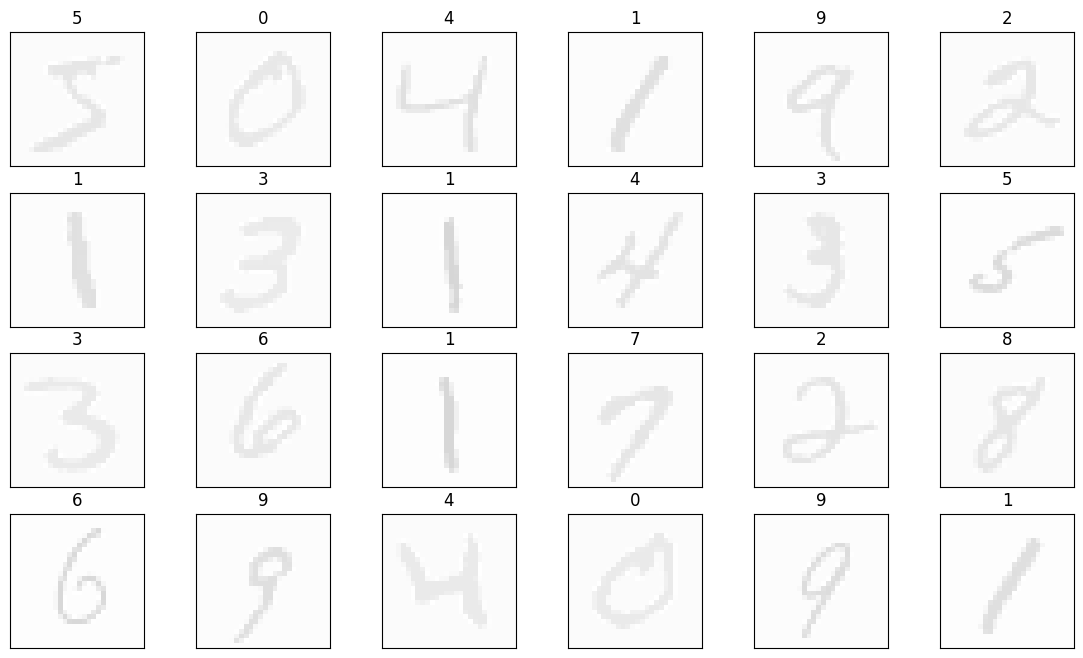

In [ ]:
# visualize the corrected images:
plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(X_corrected[i].reshape(28,28), vmin=0, vmax=1, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(mnist.targets[i]))

In [ ]:
# apply the same network as in 2b/2c:
N = 5000
X_train_corrected, X_test_corrected = X_corrected[:N], X_corrected[N:]
T_train, T_test = T[:N], T[N:]

In [ ]:
lambda_values = np.logspace(-4, 5, 10) # create 11 values of lambda from 10^-4 to 10^5
acc_train_corrected = np.zeros(10)
acc_test_corrected = np.zeros(10)

for i, lambd in enumerate(lambda_values):
    W = torch.pinverse(X_train_corrected.T @ X_train_corrected + lambd*I) @ (X_train_corrected.T @ T_train)
    Y_train_corrected = X_train_corrected @ W
    Y_test_corrected = X_test_corrected @ W
    acc_train_corrected[i] = torch.sum(torch.argmax(Y_train_corrected, axis=1)==torch.argmax(T_train, axis=1))/len(Y_train_corrected)
    acc_test_corrected[i]  = torch.sum(torch.argmax(Y_test_corrected, axis=1)==torch.argmax(T_test, axis=1))/len(Y_test_corrected)

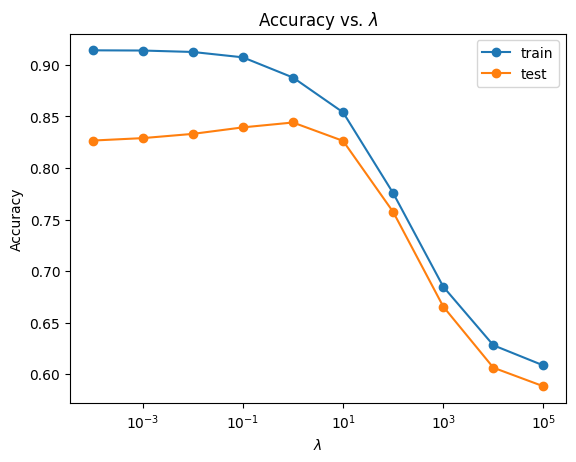

In [ ]:
# plot train and test accuracy vs. lambda
fig, ax = plt.subplots()
ax.plot(lambda_values, acc_train_corrected, 'o-', label='train')
ax.plot(lambda_values, acc_test_corrected, 'o-', label='test')
ax.set_title('Accuracy vs. $\lambda$')
ax.set(xlabel='$\lambda$', ylabel='Accuracy')
ax.set(xscale='log')
ax.legend()
plt.show()

### Discussion Questions:
***- How does the performance of the network compare to that of 2b) and 2c)?***

The network performs much better than in 2c) with the noisy data. The corrected dataset has lower contrast than the original dataset, but has much more consistency than the uncorrected data.

***- Do any of the three transformations above correspond to processing that occurs in the eye before the signal is sent to the rest of the brain?***

Subtracting the mean – this is like what happens in
Absolute value – this is like the transformation that is done by the ON and OFF phototransduction pathways of cones. ON pathways preserve the sign of the signal, and OFF pathways invert the sign via inhibitory signaling ...
Normalizing –

***- Given this result, why does the eye transform the data between raw rods & cones and the ganglion cells?***

The eye transforms incoming data because in doing so, it is able to reliably detect features of visual stimuli. The experiment above shows that the additional step of correcting (or transforming) the data leads to significantly better performance, which is an important part of being aware of one's surroundings. The ability to do this provides a significant biological/evolutionary advantage.

# 3. Classifying Stimuli Using Backpropogation

Regression is restricted to learning the layer of weights that produces the final output.  If we want to also learn what features are most useful for producing that output, we need a more complex learning rule, and this is typically backpropogation.  Here we will classify the same data as in question 2, and we will build up different network structures to do so.

Backpropogation tends to work best when learning on a bunch of data at the same time (a "batch").  The following code will set up the same training and testing data as in question 2, but presented in randomized batches of 1000 at a time.

```python
mnist = torchvision.datasets.MNIST(root='.', download=True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000)),
                                           batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000, 10000)),
                                          batch_size=1000, shuffle=True)
```

To create a neural network, we need to define what the weights are we will learn and we need to define the computation that the network will perform.  Here is the definition of a simple network that has an input of 784 values (the MNIST inputs), which go to 50 "hidden"-layer neurons, and then to the output 10 neurons.  So the network will learn to transform the 784 inputs into 50 new representations, and from those 50 features it will learn weights to create an output of 10 values (our 10 categories).  This is known as a multi-layer perceptron, or a standard neural network with a single hidden layer.

```python
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # these will be learned
        self.fc1 = nn.Linear(784, 50)   # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(50, 10)    # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = x.view(-1, 784)             # flatten the input from 28x28 to 784 values
        x = F.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = self.fc2(x)                 # apply the second set of weights
        return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category
    
network = Net()
```

Finally, we need to train our model.  When training, it is useful to keep track of how well the model is doing on the testing data.  Since testing the network takes time, we don't necessarily want to do it all the time.  Instead, the following code trains the network 10 times, and then records how well the network does on the training data and on the testing data.

```python
# create the learning rule
optimizer = optim.SGD(network.parameters(),
                      lr=0.1,   # learning rate
                      momentum=0.5)

# variables to keep track of the training and testing accuracy
accuracy_train = []
accuracy_test = []

def continue_training():
    network.train()      # configure the network for training
    for i in range(10):  # train the network 10 times
        correct = 0
        for data, target in train_loader:       # working in batchs of 1000
            optimizer.zero_grad()               # initialize the learning system
            output = network(data)              # feed in the data
            loss = F.nll_loss(output, target)   # compute how wrong the output is
            loss.backward()                     # change the weights to reduce error
            optimizer.step()                    # update the learning rule
            
            pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
            correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
    # update the list of training accuracy values
    score = float(correct/len(train_loader.dataset))
    accuracy_train.append(score)
    print('Iteration', len(accuracy_train), 'Training accuracy:', score)
    
    correct = 0
    network.eval()
    for data, target in test_loader:    # go through the test data once (in groups of 1000)
        output = network(data)                               # feed in the data
        pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
        correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
    # update the list of testing accuracy values
    score = float(correct/len(test_loader.dataset))
    accuracy_test.append(score)
    print('Iteration', len(accuracy_test), 'Testing accuracy:', score)

```

Given the above code, you can train your network 10 times by doing

```python
for i in range(10):
    continue_training()
```

If you want to continue training even more, you can just run that `for` loop again.

To plot the final accuracy results, you can use

```python
plt.figure(figsize=(12,4))
plt.plot(accuracy_train, label='training')
plt.plot(accuracy_test, label='testing')
plt.legend()
plt.xlabel('training iterations')
plt.ylabel('accuracy')
plt.show()
```

**3. a) [1 mark]** Run the model above for 10 iterations (i.e. call `continue_training` 10 times).

- Plot the training and testing accuracy.  
- Is this model better or worse than the best models developed in question 2?

In [ ]:
# load the MNIST data in batches of 1000
mnist = torchvision.datasets.MNIST(root='.', download=True, transform=torchvision.transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000)), batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000, 10000)), batch_size=1000, shuffle=True)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# modify the Net class to include the hidden layer size as an argument (will be used in 3c)
class Net(nn.Module):
    def __init__(self, hidden_size=50):
        super(Net, self).__init__()
        # these will be learned
        self.fc1 = nn.Linear(784, hidden_size)   # the weights from the input to the new learned features (hidden layer)
        self.fc2 = nn.Linear(hidden_size, 10)    # the weights from the hidden layer to the output

    def forward(self, x):
        # the processing the network will do
        x = x.view(-1, 784)             # flatten the input from 28x28 to 784 values
        x = F.relu(self.fc1(x))         # apply the first set of weights, then apply the ReLU neuron model
        x = self.fc2(x)                 # apply the second set of weights
        return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category

In [ ]:
# create the model and learning rule:
LR = 0.1
MOMENTUM = 0.5

network = Net()
optimizer = torch.optim.SGD(network.parameters(), lr=LR, momentum=MOMENTUM)

In [ ]:
def continue_training(train_list, test_list):
    network.train()      # configure the network for training
    for i in range(10):  # train the network 10 times
        correct = 0
        for data, target in train_loader:       # working in batchs of 1000
            optimizer.zero_grad()               # initialize the learning system
            output = network(data)              # feed in the data
            loss = F.nll_loss(output, target)   # compute how wrong the output is
            loss.backward()                     # change the weights to reduce error
            optimizer.step()                    # update the learning rule

            pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
            correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs
    # update the list of training accuracy values
    train_score = float(correct/len(train_loader.dataset))
    train_list.append(train_score)
    print(f'Iteration {len(train_list)} of 10 - training accuracy: {train_score:.8f}')

    correct = 0
    network.eval()
    for data, target in test_loader:    # go through the test data once (in groups of 1000)
        output = network(data)                               # feed in the data
        pred = output.data.max(1, keepdim=True)[1]           # compute which output is largest
        correct += pred.eq(target.data.view_as(pred)).sum()  # compute the number of correct outputs

    # update the list of testing accuracy values
    test_score = float(correct/len(test_loader.dataset))
    test_list.append(test_score)
    print(f'Iteration {len(test_list)} of 10 - testing accuracy: {test_score:.8f}')

In [ ]:
# variables to keep track of the training and testing accuracy
accuracy_train_3a = []
accuracy_test_3a = []

for i in range(10):
    continue_training(accuracy_train_3a, accuracy_test_3a)

<ipython-input-22-35f5fe1f641d>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category


Iteration 1 of 10 - training accuracy: 0.8608
Iteration 1 of 10 - testing accuracy: 0.8562
Iteration 2 of 10 - training accuracy: 0.9014
Iteration 2 of 10 - testing accuracy: 0.8852
Iteration 3 of 10 - training accuracy: 0.9156
Iteration 3 of 10 - testing accuracy: 0.8924
Iteration 4 of 10 - training accuracy: 0.9260
Iteration 4 of 10 - testing accuracy: 0.9004
Iteration 5 of 10 - training accuracy: 0.9330
Iteration 5 of 10 - testing accuracy: 0.9052
Iteration 6 of 10 - training accuracy: 0.9380
Iteration 6 of 10 - testing accuracy: 0.9070
Iteration 7 of 10 - training accuracy: 0.9416
Iteration 7 of 10 - testing accuracy: 0.9086
Iteration 8 of 10 - training accuracy: 0.9448
Iteration 8 of 10 - testing accuracy: 0.9100
Iteration 9 of 10 - training accuracy: 0.9494
Iteration 9 of 10 - testing accuracy: 0.9108
Iteration 10 of 10 - training accuracy: 0.9524
Iteration 10 of 10 - testing accuracy: 0.9106


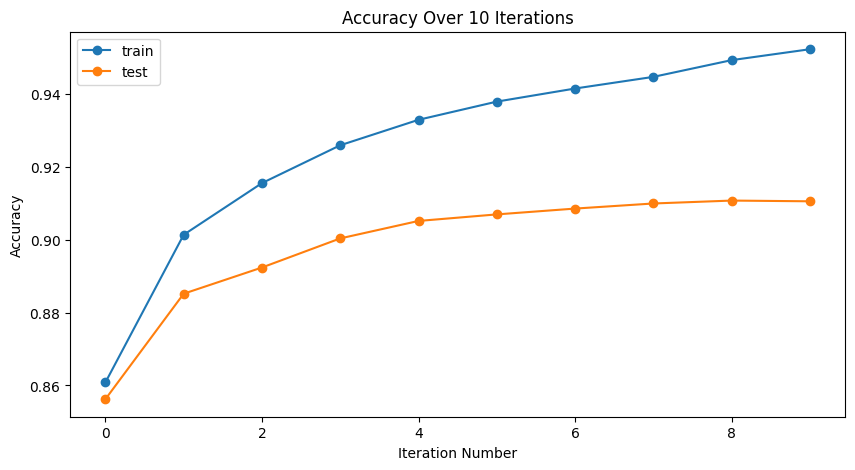

In [ ]:
# plot the training and testing accuracy over 10 iterations
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(accuracy_train_3a, 'o-', label='train')
ax.plot(accuracy_test_3a, 'o-', label='test')
ax.set_title('Accuracy Over 10 Iterations')
ax.set_xlabel('Iteration Number')
ax.set_ylabel('Accuracy')
ax.legend()

### Discussion Question:
***- Is this model better or worse than the best models developed in question 2?***
# TODO

**3. b) [1 mark]** Repeat question 3a five times.  This does not mean to run a single model for 50 iterations.  Rather, you need to reset the model and train it again.  The easiest way to do this is to recreate the network and the optimizer like this:

```python
network = Net()
optimizer = optim.SGD(network.parameters(),
                      lr=0.1,
                      momentum=0.5)
```

- Make a plot showing the 5 different training accuracies and 5 different testing accuracies
- Also show the average training and testing accuracy on the plot.
- Each of the 5 models should show slightly different accuracies.  Why is this the case?


<ipython-input-22-35f5fe1f641d>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category


Iteration 1 of 10 - training accuracy: 0.8596
Iteration 1 of 10 - testing accuracy: 0.8530
Iteration 2 of 10 - training accuracy: 0.9000
Iteration 2 of 10 - testing accuracy: 0.8824
Iteration 3 of 10 - training accuracy: 0.9142
Iteration 3 of 10 - testing accuracy: 0.8956
Iteration 4 of 10 - training accuracy: 0.9248
Iteration 4 of 10 - testing accuracy: 0.8998
Iteration 5 of 10 - training accuracy: 0.9312
Iteration 5 of 10 - testing accuracy: 0.9032
Iteration 6 of 10 - training accuracy: 0.9390
Iteration 6 of 10 - testing accuracy: 0.9052
Iteration 7 of 10 - training accuracy: 0.9414
Iteration 7 of 10 - testing accuracy: 0.9076
Iteration 8 of 10 - training accuracy: 0.9464
Iteration 8 of 10 - testing accuracy: 0.9082
Iteration 9 of 10 - training accuracy: 0.9490
Iteration 9 of 10 - testing accuracy: 0.9098
Iteration 10 of 10 - training accuracy: 0.9544
Iteration 10 of 10 - testing accuracy: 0.9114
Iteration 1 of 10 - training accuracy: 0.8604
Iteration 1 of 10 - testing accuracy: 0.85

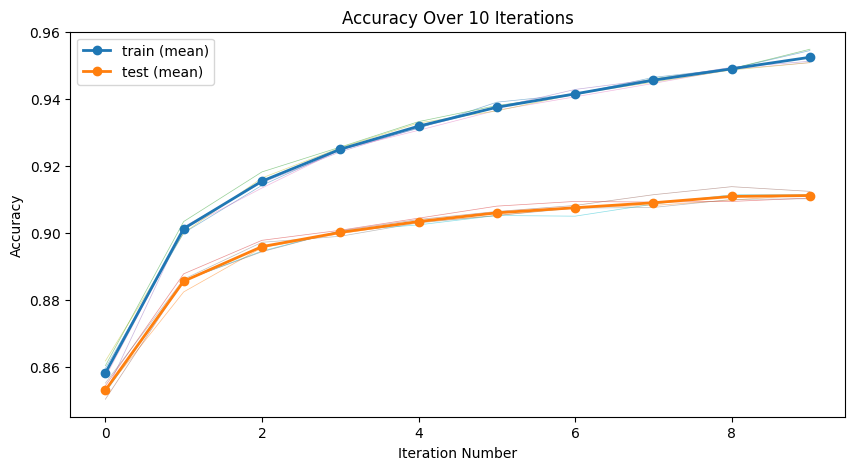

In [ ]:
# repeat the above 5 times and plot train and test accuracy:
fig, ax = plt.subplots(figsize=(10,5))
train_mean_3b = np.zeros(10)
test_mean_3b = np.zeros(10)

for i in range(5):
    accuracy_train = []
    accuracy_test = []
    network = Net()
    optimizer = torch.optim.SGD(network.parameters(), lr=LR, momentum=MOMENTUM)
    for j in range(10):
        continue_training(accuracy_train, accuracy_test)
    ax.plot(accuracy_train, linewidth=0.5, alpha=0.5)
    ax.plot(accuracy_test, linewidth=0.5, alpha=0.5)
    train_mean_3b += np.array(accuracy_train)
    test_mean_3b += np.array(accuracy_test)

train_mean_3b /= 5
test_mean_3b /= 5

ax.plot(train_mean_3b, 'o-', linewidth=2, label='train (mean)')
ax.plot(test_mean_3b, 'o-', linewidth=2, label='test (mean)')
ax.set_title('Accuracy Over 10 Iterations')
ax.set_xlabel('Iteration Number')
ax.set_ylabel('Accuracy')
ax.legend()

**3. c) [1 mark]** Repeat question 3b varying the number of neurons in the hidden layer of the network.  The current value is 50.  Try it with 5, 10, 20, 50, and 100 neurons.  For each number of neurons, repeat five times and take the average (like in question 3b).  

- Plot the final testing accuracy on the y-axis and the number of neurons on the x-axis.  Note that to speed things up you can remove the testing computation from continue_training until the very end, since we only need the final testing score.


In [ ]:
# repeat 3b) with different hidden layer sizes:
hidden_sizes = [5, 10, 20, 50, 100]
train_3c = np.zeros((len(hidden_sizes), 5)) # save one value for each hidden layer size and each of 5 trials
test_3c = np.zeros((len(hidden_sizes), 5))

for k in range(len(hidden_sizes)):
    print(f'Hidden layer size: {hidden_sizes[k]}')
    for i in range(5): # repeat the above 5 times for each hidden layer size
        print(f"Trial {i} of 5")
        accuracy_train = []
        accuracy_test = []
        network = Net(hidden_size=hidden_sizes[k])
        optimizer = torch.optim.SGD(network.parameters(), lr=LR, momentum=MOMENTUM)
        for j in range(10):
            continue_training(accuracy_train, accuracy_test)
        train_3c[k][i] += np.array(accuracy_train[-1]) # take last element of accuracy_train list (model accuracy after 10 iterations)
        print(f"Current train mean: {train_3c[k][i]}")
        test_3c[k][i] += np.array(accuracy_test[1])
        print(f"Current test mean: {test_3c[k][i]}")

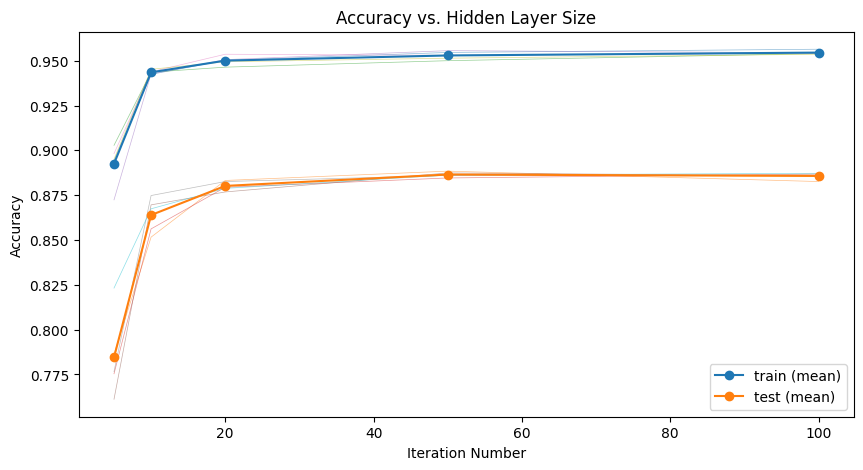

In [ ]:
# plot accuracy vs. hidden layer size
fig, ax = plt.subplots(figsize=(10,5))

# plot each trial
for i in range(5):
    ax.plot(hidden_sizes, train_3c[:,i], linewidth=0.5, alpha=0.5)
    ax.plot(hidden_sizes, test_3c[:,i], linewidth=0.5, alpha=0.5)

# plot mean of all trials
ax.plot(hidden_sizes, np.mean(train_3c, axis=1), 'o-', linewidth=2, label='train (mean)')
ax.plot(hidden_sizes, np.mean(test_3c, axis=1), 'o-', linewidth=2, label='test (mean)')
ax.set_title('Accuracy vs. Hidden Layer Size')
ax.set_xlabel('Iteration Number')
ax.set_ylabel('Accuracy')
ax.legend()

**3. d) [2 marks]** Now we will add a convolution layer to our network.  The following network adds two convolution layers before two normal neural network layers.

```python
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)  # set the size of the convolution to 5x5, and have 12 of them
        self.conv2 = nn.Conv2d(12, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # make sure to do max pooling after the convolution layers
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)
```

The following code can be used to plot the learned features in the first layer:
```python
plt.figure(figsize=(12,5))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(network.conv1.weight[i][0].detach().numpy(), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.show()
```

- Train the model through 40 iterations and generate a plot of training and testing accuracy over time.
- Does this perform better or worse than the previous models in this assignment?
- What advantages and disadvantages do you see with this approach (in comparison to the previous parts of the assignment)?
- Plot the features learned by the first convolution layer.  How do they compare to real features detected in the V1 area of the brain?

In [ ]:
# define convolutional nnet class:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)  # set the size of the convolution to 5x5, and have 12 of them
        self.conv2 = nn.Conv2d(12, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # make sure to do max pooling after the convolution layers
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
# train for 40 iterations, plot train and test accuracy over time:
network = ConvNet()
optimizer = torch.optim.SGD(network.parameters(), lr=LR, momentum=MOMENTUM)
accuracy_train_3d = []
accuracy_test_3d = []

continue_training(accuracy_train_3d, accuracy_test_3d, num_iters=40)


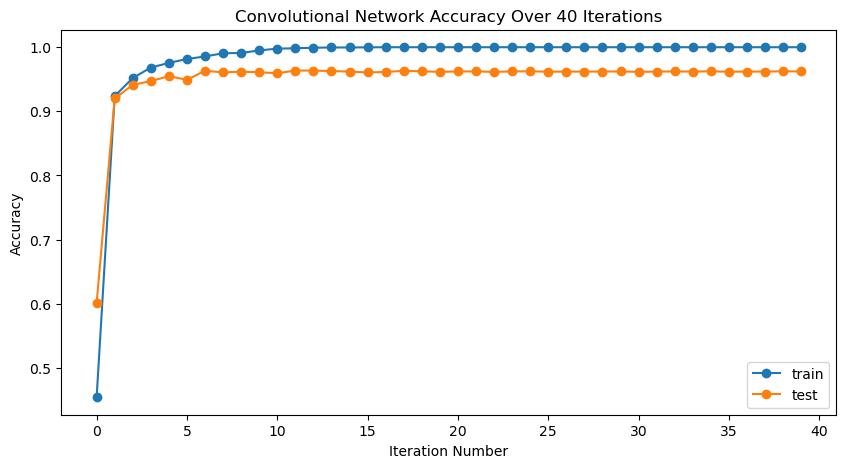

In [ ]:
# plot train and test accuracy vs. iteration:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(accuracy_train_3d, 'o-', label='train')
ax.plot(accuracy_test_3d, 'o-', label='test')
ax.set_title('Convolutional Network Accuracy Over 40 Iterations')
ax.set_xlabel('Iteration Number')
ax.set_ylabel('Accuracy')
ax.legend()

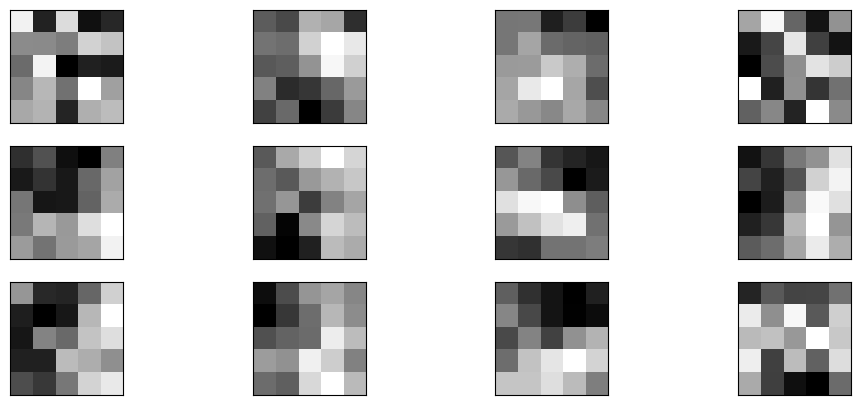

In [ ]:
# plot the features learned by the first convolution layer:
plt.figure(figsize=(12,5))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(network.conv1.weight[i][0].detach().numpy(), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
print(f"Training accuracy: {accuracy_train[-1]:.4f}")
print(f"Testing accuracy: {accuracy_test[-1]:.4f}")

Training accuracy: 0.9590
Testing accuracy: 0.9162


### Discussion Questions:

***- Does this perform better or worse than the previous models in this assignment?***

From the result above, this model performs much better than previous models from earlier in the assignment, with a test accuracy of about 96% (compared to less than 90% in previous attempts).

***- What advantages and disadvantages do you see with this approach (in comparison to the previous parts of the assignment)?***

The obvious advantage of this approach is that it can achieve a much higher accuracy than before, so it does better at the task that we want to accomplish.

Also works well on a smaller dataset compared to regression? (5000 vs 60,000 samples?) This means that this method would be more applicable to tasks that have comparatively limited data available to train on.

One potential disadvantage of this method is that it is slower and requires more resources compared to simpler networks. For this relatively trivial task, however, this a major issue—we can see that comparable accuracy can be achieved after training for only 10 iterations. For more complex tasks, I would expect that convolutional networks can be quite computationally intensive compared to simple regression.

Another limitation is that the CNN does not offer transparency into the features that the model is using. In the visualization above, for example, the "features" have been identified are not clearly linked to the inputs, and more layers complicate this further. This makes for a very "black box" kind of solution, which cannot be easily interpreted by a human. In a case where the model is unsuccessful, this can make it difficult to understand what is going wrong.

***- Plot the features learned by the first convolution layer. How do they compare to real features detected in the V1 area of the brain?***

The features learned by the first layer are very different from the features detected in V1. These also look different each time the network is trained, which indicates that there is nothing "special" about these particular features.

**BONUS [1 mark]** Try to improve the neural network. You want to get the best testing accuracy you can. Try at least two different approaches and report your results.

### 1. Try using more layers

In [ ]:
network = Net()
optimizer = torch.optim.SGD(network.parameters(), lr=LR, momentum=MOMENTUM)

### 2. Try a different kernel size

In [ ]:
# vary the kernel size:
class Net(nn.Module):
    def __init__(self, k=5, hidden_size=50):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, k, padding=1)  # set the size of the convolution to 5x5, and have 12 of them
        self.conv2 = nn.Conv2d(12, 20, k, padding=1)
        self.fc1 = nn.Linear(320, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # make sure to do max pooling after the convolution layers
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
# vary the kernel size to see how this affects accuracy:
kernel_sizes = [2, 3, 5, 7, 9, 11]
train_b2 = np.zeros((len(kernel_sizes), 5))
test_b2 = np.zeros((len(kernel_sizes), 5))

for n in range(len(kernel_sizes)):
    for i in range(5):
        accuracy_train = []
        accuracy_test = []
        network = Net(k=kernel_sizes[n])
        optimizer = torch.optim.SGD(network.parameters(), lr=LR, momentum=MOMENTUM)
        for j in range(10):
            continue_training(accuracy_train, accuracy_test)
        train_b2[n][i] = accuracy_train[-1]
        test_b2[n][i] = accuracy_test[-1]

RuntimeError: shape '[-1, 320]' is invalid for input of size 980000

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

# plot kernel size vs. accuracy
for i in range(5):
    ax.plot(kernel_sizes, train_b2[:,i], linewidth=0.5, alpha=0.5)
    ax.plot(kernel_sizes, test_b2[:,i], linewidth=0.5, alpha=0.5)

ax.plot(kernel_sizes, train_b2, 'o-', label='train (mean)')
ax.plot(kernel_sizes, test_b2, 'o-', label='test (mean)')
ax.set_title('Accuracy vs. Kernel Size')
ax.set_xlabel('Kernel Size')
ax.set_ylabel('Accuracy')
ax.legend()

### 3. Try a different learning rate

In [ ]:
# vary the learning rate to see how this affects accuracy:
learning_rates = np.logspace(-4, 5, 10)

train_b3 = np.zeros((len(learning_rates), 5))
test_b3 = np.zeros((len(learning_rates), 5))

for l in range(len(learning_rates)):
    for i in range(5):
        accuracy_train = []
        accuracy_test = []
        network = Net()
        optimizer = torch.optim.SGD(network.parameters(), lr=l, momentum=MOMENTUM)
        for j in range(10):
            continue_training(accuracy_train, accuracy_test)
        train_b3[l][i] = accuracy_train[-1]
        test_b3[l][i] = accuracy_test[-1]

<ipython-input-38-35f5fe1f641d>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)         # apply a softmax function as we just want one large output indicating category


Iteration 1 of 10 - training accuracy: 0.0996
Iteration 1 of 10 - testing accuracy: 0.1050
Iteration 2 of 10 - training accuracy: 0.0996
Iteration 2 of 10 - testing accuracy: 0.1050
Iteration 3 of 10 - training accuracy: 0.0996
Iteration 3 of 10 - testing accuracy: 0.1050
Iteration 4 of 10 - training accuracy: 0.0996
Iteration 4 of 10 - testing accuracy: 0.1050
Iteration 5 of 10 - training accuracy: 0.0996
Iteration 5 of 10 - testing accuracy: 0.1050
Iteration 6 of 10 - training accuracy: 0.0996
Iteration 6 of 10 - testing accuracy: 0.1050
Iteration 7 of 10 - training accuracy: 0.0996
Iteration 7 of 10 - testing accuracy: 0.1050
Iteration 8 of 10 - training accuracy: 0.0996
Iteration 8 of 10 - testing accuracy: 0.1050
Iteration 9 of 10 - training accuracy: 0.0996
Iteration 9 of 10 - testing accuracy: 0.1050
Iteration 10 of 10 - training accuracy: 0.0996
Iteration 10 of 10 - testing accuracy: 0.1050
Iteration 1 of 10 - training accuracy: 0.0842
Iteration 1 of 10 - testing accuracy: 0.08

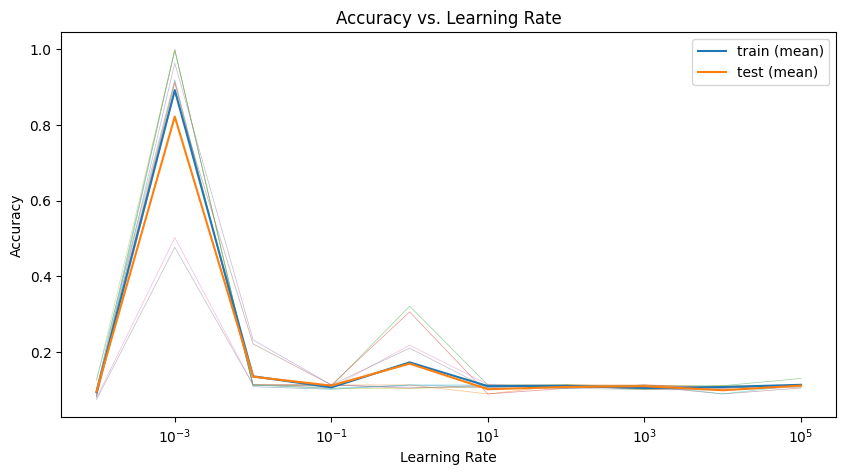

In [ ]:
# plot accuracy vs. learning rate
fig, ax = plt.subplots(figsize=(10,5))

for i in range(5):
    ax.plot(learning_rates, train_b3[:,i], linewidth=0.5, alpha=0.5)
    ax.plot(learning_rates, test_b3[:,i], linewidth=0.5, alpha=0.5)

ax.plot(learning_rates, train_b3.mean(axis=1), label='train (mean)')
ax.plot(learning_rates, test_b3.mean(axis=1), label='test (mean)')
ax.set_title('Accuracy vs. Learning Rate')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Accuracy')
ax.set_xscale('log')
ax.legend()

### Discussion:

The results above show ...


One other modification that could be interesting to explore is trying out different optimizers such as RMSProp or Adam. From some quick research, RMSProp is faidrly common, and the Adam optimizer converges quickly (but generalizes less well compared to SGD) [1].

#### References
[1] P. Zhou, J. Feng, C. Ma, C. Xiong, S. Hoi, and E. Weinan, "Towards Theoretically Understanding Why SGD Generalizes Better Than ADAM in Deep Learning," _Conference on Neural Information Processing Systems (NeurIPS 2020)_, Vancouver, Canada. Available: https://proceedings.neurips.cc/paper/2020/file/f3f27a324736617f20abbf2ffd806f6d-Paper.pdf
